# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

### Model description

- Model architecture: MobileNet V2 
- Fractal module used: None 
- Number of layers tuned: 2

### Load the ISIC Archive dataset

In [3]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [4]:
class LesionClassifier(tf.keras.Model):
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.inside_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.inside_model.layers:
            if layer.name in ['lock_16_project ', 'block_16_project_BN']:
                layer.trainable = True
            else:
                layer.trainable = False           
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        outputs = self.inside_model(inputs)
        outputs = self.dense(outputs)
        
        return outputs

In [5]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [6]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [7]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [8]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [9]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
947/947 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.7102
Epoch 1: val_loss improved from inf to 0.84227, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 8153s 9s/step - loss: 0.9006 - accuracy: 0.7102 - val_loss: 0.8423 - val_accuracy: 0.7179
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 0.8076 - accuracy: 0.7275
Epoch 2: val_loss improved from 0.84227 to 0.79750, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 7512s 8s/step - loss: 0.8076 - accuracy: 0.7275 - val_loss: 0.7975 - val_accuracy: 0.7317
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.7361
Epoch 3: val_loss improved from 0.79750 to 0.77476, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 6415s 7s/step - loss: 0.7861 - accuracy: 0.7361 - val_loss: 0.7748 - val_accuracy: 0.7415
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.7411
Epoch 4: val_loss did not improve from 0.77476
947/947 [==============================] - 5517s 6s/step - loss: 0.7631 - accuracy: 0.7411 - val_loss: 0.7779 - val_accuracy: 0.7377
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.7441
Epoch 5: val_loss improved from 0.77476 to 0.75619, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4905s 5s/step - loss: 0.7505 - accuracy: 0.7441 - val_loss: 0.7562 - val_accuracy: 0.7427
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.7472
Epoch 6: val_loss did not improve from 0.75619
947/947 [==============================] - 4209s 4s/step - loss: 0.7444 - accuracy: 0.7472 - val_loss: 0.7617 - val_accuracy: 0.7385
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 0.7360 - accuracy: 0.7499
Epoch 7: val_loss did not improve from 0.75619
947/947 [==============================] - 4117s 4s/step - loss: 0.7360 - accuracy: 0.7499 - val_loss: 0.7580 - val_accuracy: 0.7428
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 0.7295 - accuracy: 0.7508
Epoch 8: val_loss improved from 0.75619 to 0.74810, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 3991s 4s/step - loss: 0.7295 - accuracy: 0.7508 - val_loss: 0.7481 - val_accuracy: 0.7394
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 0.7257 - accuracy: 0.7511
Epoch 9: val_loss did not improve from 0.74810
947/947 [==============================] - 10472s 11s/step - loss: 0.7257 - accuracy: 0.7511 - val_loss: 0.7575 - val_accuracy: 0.7451
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 0.7223 - accuracy: 0.7505 
Epoch 10: val_loss improved from 0.74810 to 0.74741, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 12404s 13s/step - loss: 0.7223 - accuracy: 0.7505 - val_loss: 0.7474 - val_accuracy: 0.7452


### Testing

In [10]:
model.load_weights(checkpoint_path)

In [11]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [12]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 317s 2s/step


In [13]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [14]:
auc_metric

{'actinic keratosis': 0.9438042244384983,
 'basal cell carcinoma': 0.9303098610978304,
 'dermatofibroma': 0.8454456849193691,
 'melanoma': 0.8636039922065784,
 'nevus': 0.9159314662710248,
 'pigmented benign keratosis': 0.9095526631792522,
 'seborrheic keratosis': 0.8604723273196722,
 'solar lentigo': 0.8676847732047954,
 'squamous cell carcinoma': 0.9069003439314659,
 'vascular lesion': 0.9667589820359281}

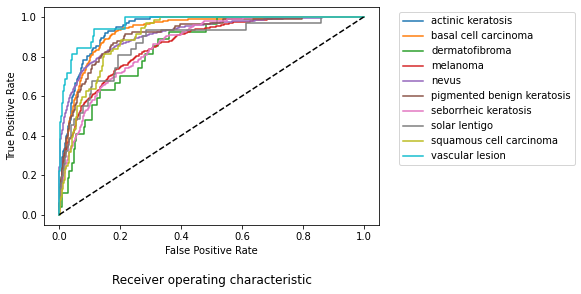

In [15]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [16]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

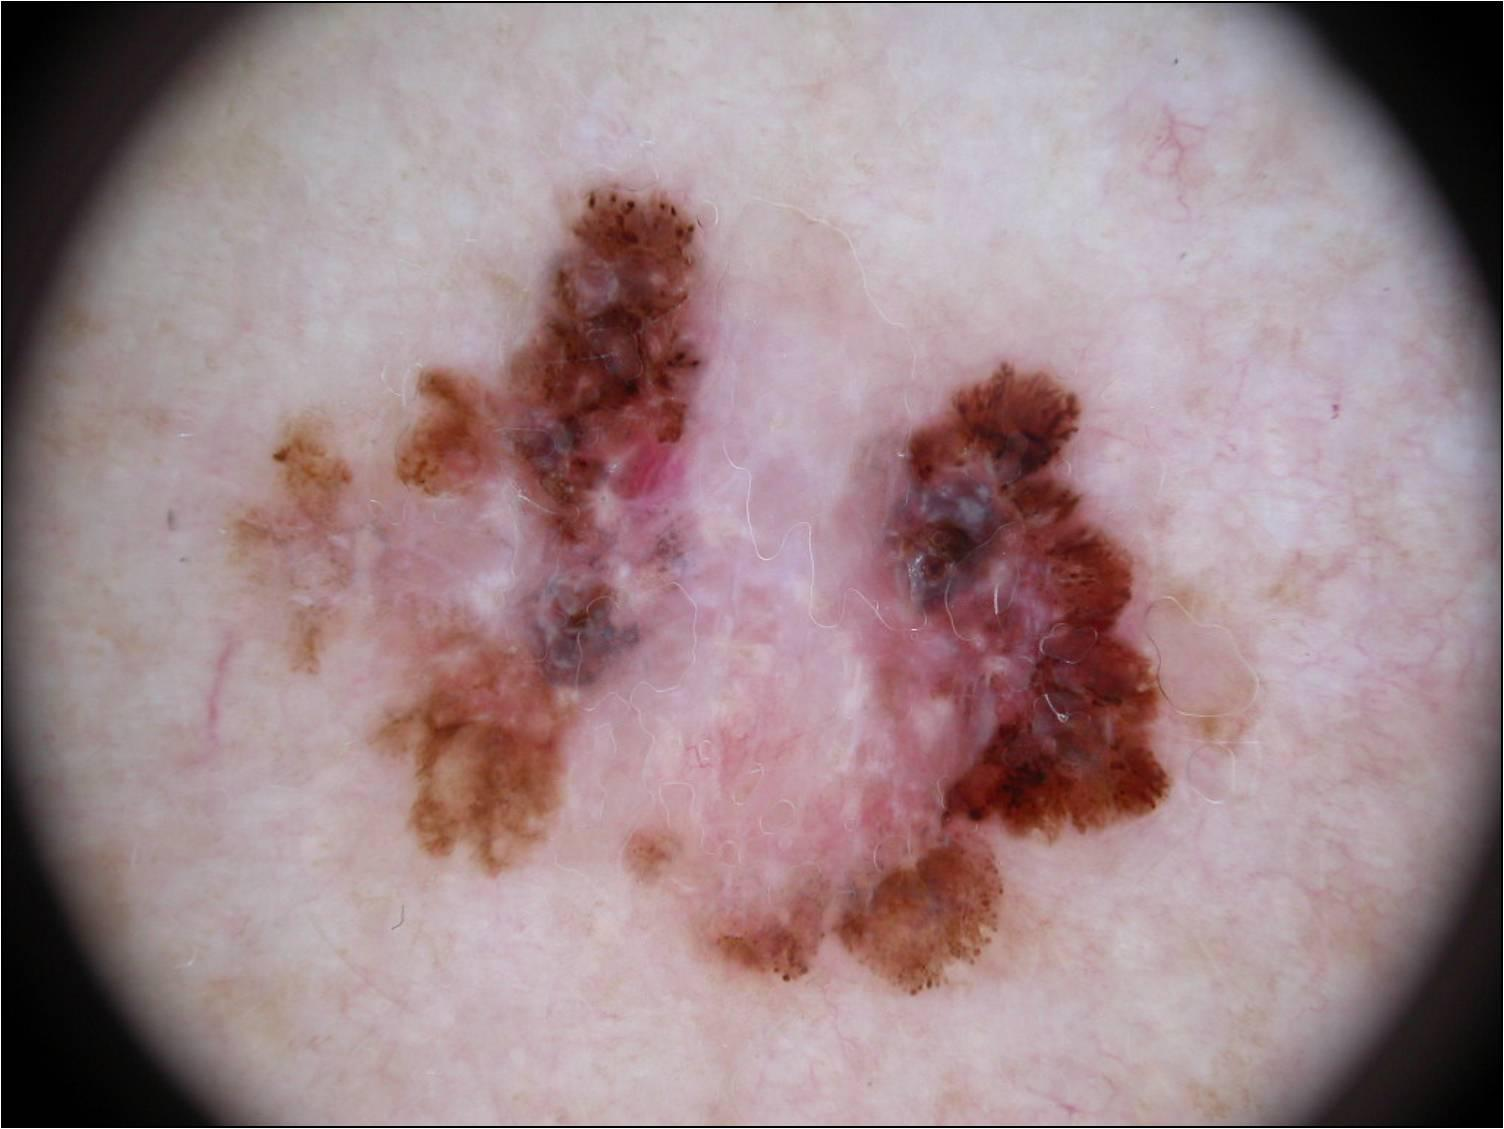

In [17]:
display(Image(melanoma_im_path, width=600))

In [18]:
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [19]:
heatmap = make_gradcam_heatmap(img_array, model.inside_model, 'block_16_project_BN')

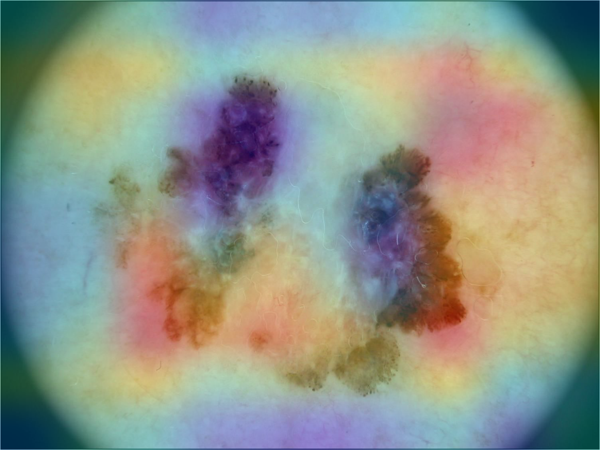

In [20]:
display_gradcam(melanoma_im_path, heatmap)